In [277]:
#Packages

import numpy as np
from amortization.amount import calculate_amortization_amount
from amortization.schedule import amortization_schedule
import matplotlib.pyplot as plt
from pyloan import pyloan
import pandas as pd

In [322]:
#Assumptions

#Loan
PurchasePrice = 600000 #Dollars
DownPayment = 60000
LoanValue = PurchasePrice-DownPayment
LTYears = 30
LoanTerm = LTYears*12 #Months
LoanRate = 6 #Rate, as a percent

#Base Costs
MaintCosts = 6000 #Dollars per year
TaxHouse = 5000 #Dollars per year

#VariableCosts
Bills = 10 #Dollars per day (rented) Assumes 300 for fully rented month
Cleaning = 30 #Dollars per day (rented) (Is this even close to accurate?)

#Income
WeekendRate = 450 #Dollars per night
WeekdayRate = 350 # Dollars per night
PercentRentedWeekend = .7 #Rate !!For MC this is a distribution, defined in section 2
PercentRentedWeekday = .4 #Rate !!For MC this is a distribution, defined in section 2


#Constants
WeekendDaysInYear = 365/7*2
WeekDaysInYear = 365/7*5
DaysinYear = 365

In [273]:
#Calculate Loan Info

LoanPayment = calculate_amortization_amount(LoanValue, LoanRate, LoanTerm)

#Schedule
AS = amortization_schedule(LoanValue, LoanRate, LoanTerm)
loan = pyloan.Loan(loan_amount=LoanValue,interest_rate=LoanRate,loan_term=LTYears,start_date='2023-07-16')

In [303]:
#Populate Loan Amortization table

payment_schedule = loan.get_payment_schedule()

schedule = pd.DataFrame.from_records(loan.get_payment_schedule(),columns=pyloan.Payment._fields)

schedule = pd.DataFrame.to_numpy(schedule)  

Balances = np.zeros([LTYears])

#Get yearly numbers
i = 0

while i < 360:
    
    if i%12 == 0:
       
        Balances[int(i/12)] = schedule[i,6]
    i+=1

        

In [92]:
Income = WeekendDaysInYear*PercentRentedWeekend*WeekendRate + WeekDaysInYear*PercentRentedWeekday*WeekdayRate #Dollars
Expenses = 12*LoanPayment + MaintCosts + TaxHouse + (PercentRentedWeekend*WeekendDaysInYear + PercentRentedWeekday*WeekDaysInYear)*(Bills+Cleaning)

In [93]:
Income-Expenses #Dollars (Per year)

8090.971428571422

# Section 2 - MonteCarlo Analysis
## 4 series are generated
### 1. Brokerage account value, subtracting loan payment from brokerage acct, not reinvesting profits
### 2. Cumulative rental income
### 3. Brokerage account value, subtracting loan payment from brokerage acct, reinvesting profits back into account
### 4. Brokerage account only, beginning balance of loan value, not purchasing property


In [316]:
#Distributions
#1YrReturnS&P https://klementoninvesting.substack.com/p/the-distribution-of-stock-market
#1Yr return housing https://www.creditkarma.com/home-loans/i/average-home-value-increase-per-year
muMkt = .1
sigmaMkt = .1

#
muwkndRentPct = .7
sigmawkndRentPct = .1

muwkRentPct = .5
sigmawkRentPct = .1

muHousing = .042
sigmaHousing = .04

#initialization
iterations = 1000
YearlyData = np.zeros([iterations,LTYears,7]) #Layer(Iteration), row(Year), column(Columns = Year, BrokerageValueNoReinvest, RentalCumulativeIncome, BrokerageValueReinvest, 600kNoHouse)
YearlyData[:,0,0] = 0 #Current year 0
YearlyData[:,0,1] = PurchasePrice #InitialBrokerageAcctValue
YearlyData[:,0,2] = 0 #initial cumulative rental income
YearlyData[:,0,3] = PurchasePrice #InitialBrokerageAcctValue
YearlyData[:,0,4] = PurchasePrice #Brokerage account value only, no property purchase
YearlyData[:,0,5] = PurchasePrice #Property Value Only
YearlyData[:,0,6] = PurchasePrice #Combined net worth, brokerage acct value, property appreciation, current loan value subtracted
i = 0 
j = 1 # j=0 already set above

In [317]:
#income and net worth calculations




while i < iterations:
    
    j=1
    while j < (30):
        
        #increment year
        YearlyData[i,j,0] = YearlyData[i,j-1,0] + 1     #Year
    
        #Randomness for stock market
        samplemkt = np.random.normal(muMkt, sigmaMkt, size=1)
        
        #Randomness for rent%
        samplewk = np.random.normal(muwkRentPct, sigmawkRentPct, size=1)
        samplewknd = np.random.normal(muwkndRentPct, sigmawkndRentPct, size=1)
        
        #Randomness for housing market
        samplehousingmkt = np.random.normal(muHousing, sigmaHousing, size = 1)
        
        
        #Calculate brokerage acct value with no Profit Reinvestment                                                                   
        YearlyData[i,j,1] = YearlyData[i,j-1,1] + YearlyData[i,j-1,1]*samplemkt - LoanPayment*12
        
        #Calculate rental cumulative income
        Income = WeekendDaysInYear*samplewknd*WeekendRate + WeekDaysInYear*samplewk*WeekdayRate #Dollars
        Expenses = 12*LoanPayment + MaintCosts + TaxHouse + (PercentRentedWeekend*WeekendDaysInYear + PercentRentedWeekday*WeekDaysInYear)*(Bills+Cleaning)
        
        YearlyData[i,j,2] = YearlyData[i,j-1,2] + Income-Expenses
        
        #Calculate acct value with profit Reinvestment                                                                   
        YearlyData[i,j,3] = YearlyData[i,j-1,3] + YearlyData[i,j-1,3]*samplemkt + (Income-Expenses)
        
        #Calculate brokerage acct value without rental property                                                                  
        YearlyData[i,j,4] = YearlyData[i,j-1,4] + YearlyData[i,j-1,4]*samplemkt
        
        #Property Value
        YearlyData[i,j,5] = YearlyData[i,j-1,5] + YearlyData[i,j-1,5]*samplehousingmkt
        
        
        #Calculate net worth including rental property appreciation = Acct value with profit reinvest + home value - loan balance
        YearlyData[i,j,6] = YearlyData[i,j,3] + YearlyData[i,j,5] - Balances[j]
        
        
        
        j+=1
    
    i+=1

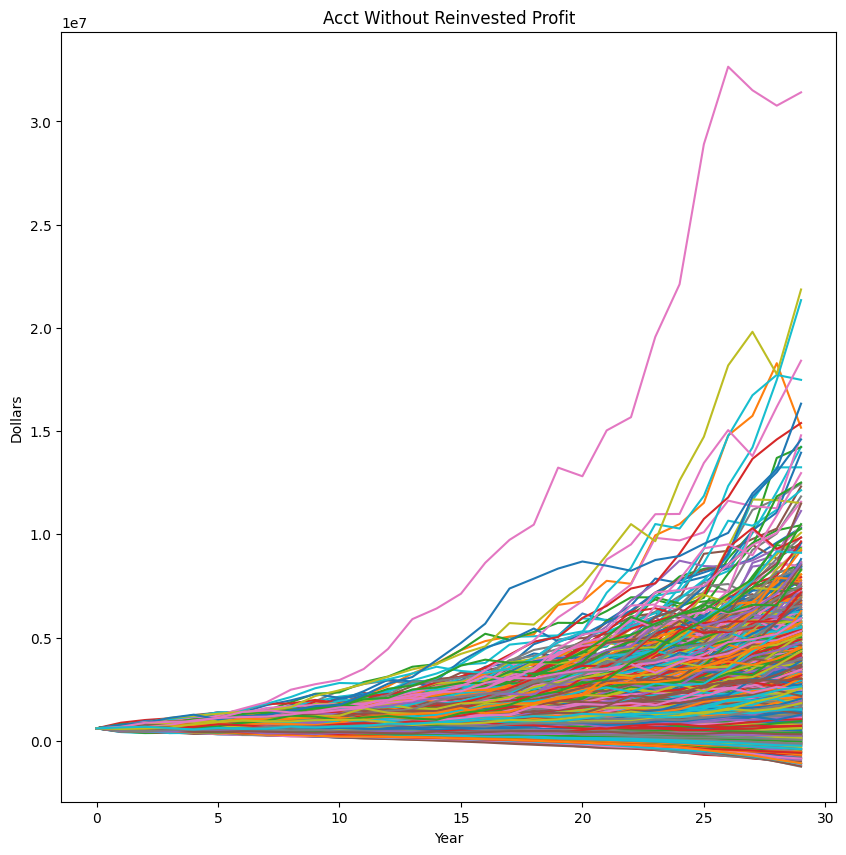

In [228]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Acct Without Reinvested Profit')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,1], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

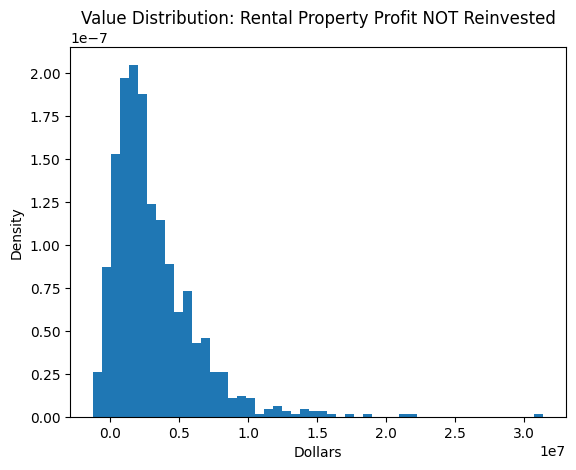

In [229]:
n, bins, patches = plt.hist(YearlyData[:,29,1], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution: Rental Property Profit NOT Reinvested')

bin_centers = 0.5 * (bins[1:] + bins[:-1])


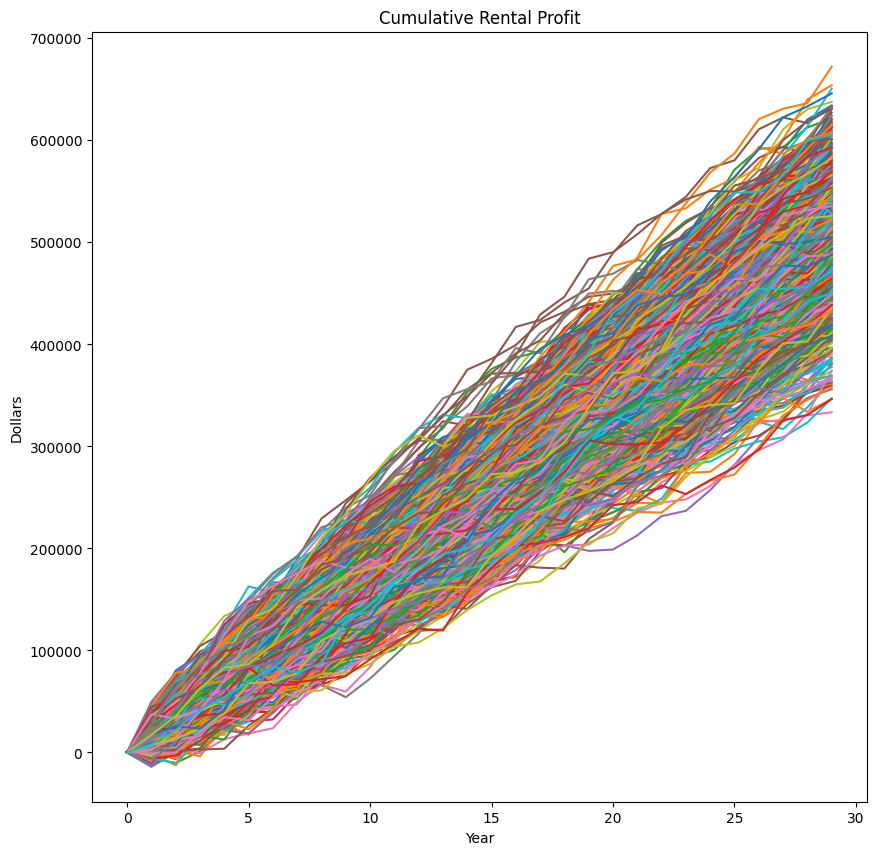

In [205]:
#Plot MonteCarlo for brokerage acct
fig = plt.figure(figsize =(10, 10))
plt.title('Cumulative Rental Profit')

for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,2], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

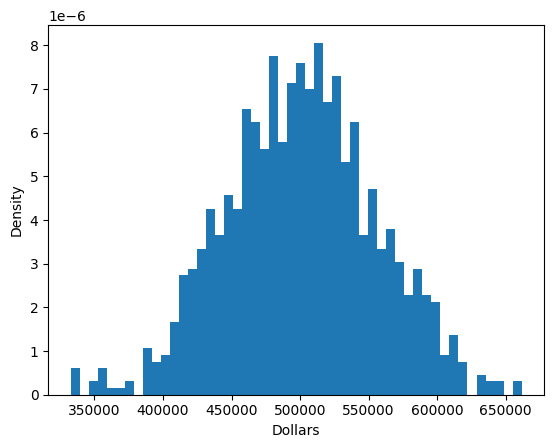

In [318]:
n, bins, patches = plt.hist(YearlyData[:,29,2], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')

bin_centers = 0.5 * (bins[1:] + bins[:-1])


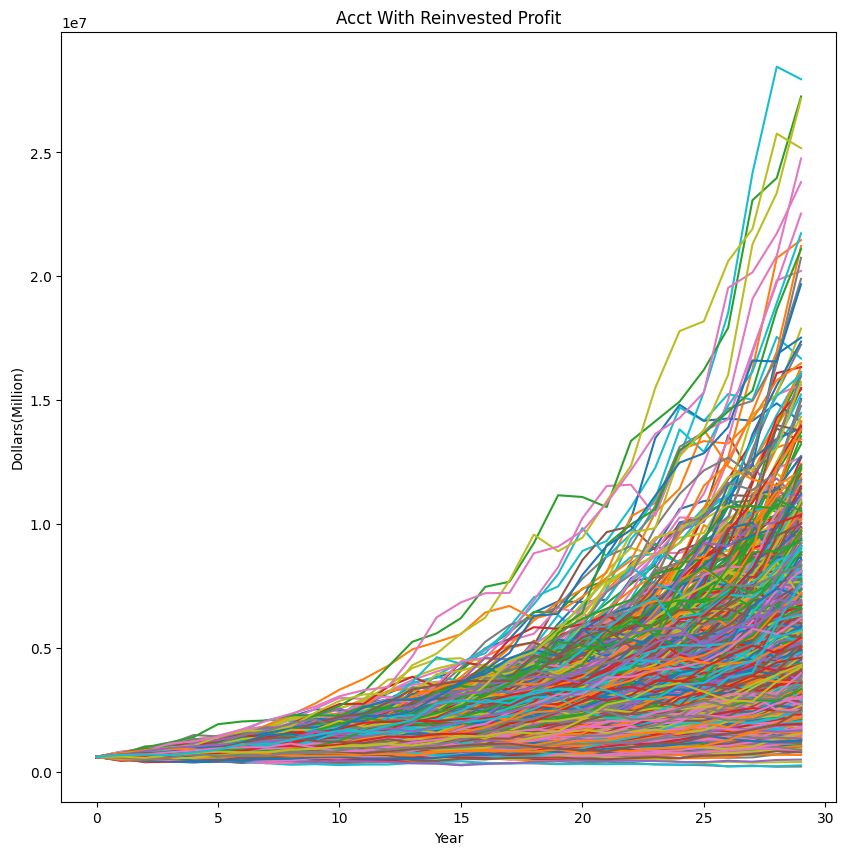

In [176]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Acct With Reinvested Profit')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,3], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars(Million)')


# Show the plot
plt.show()

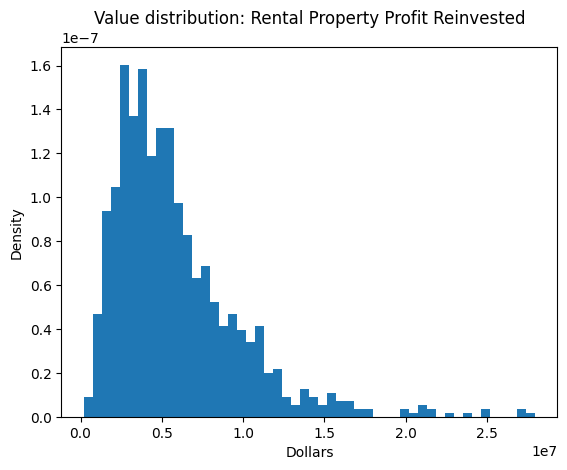

In [181]:
n, bins, patches = plt.hist(YearlyData[:,29,3], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution: Rental Property Profit Reinvested')
bin_centers = 0.5 * (bins[1:] + bins[:-1])


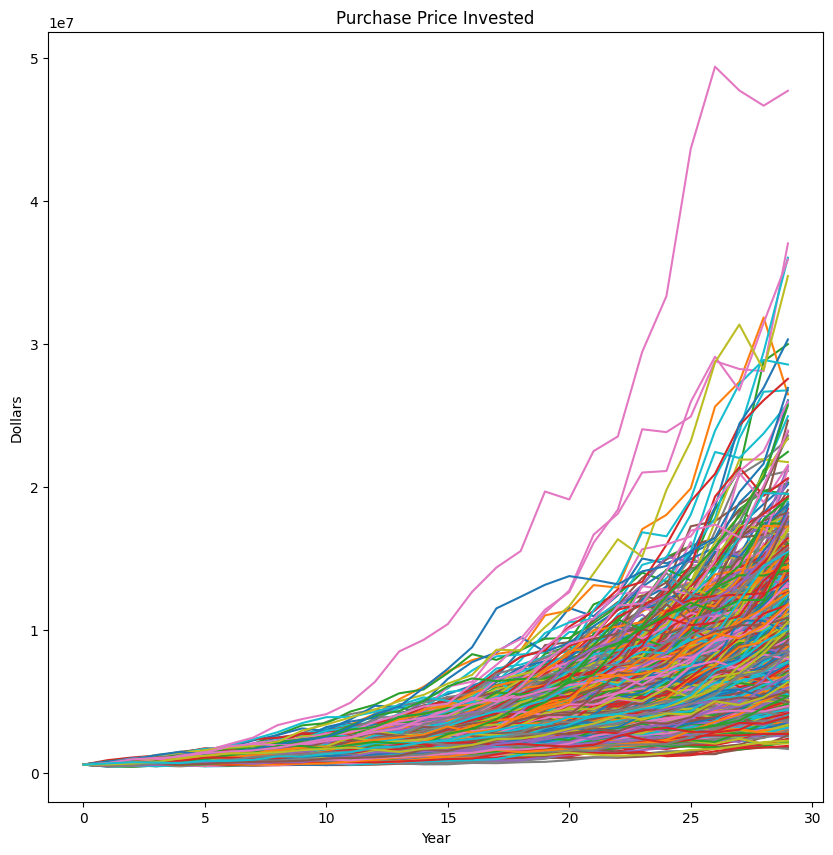

In [230]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Purchase Price Invested')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,4], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

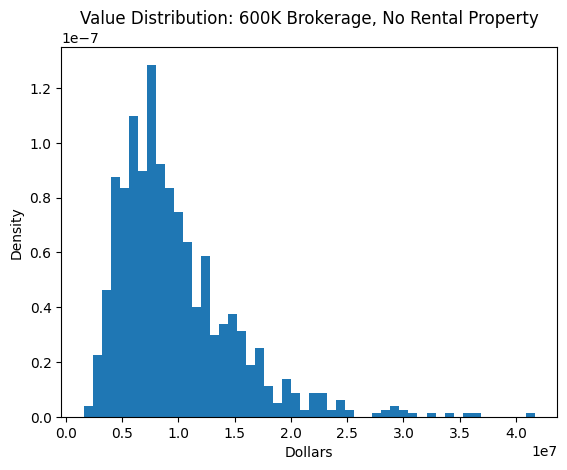

In [182]:
n, bins, patches = plt.hist(YearlyData[:,29,4], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution: 600K Brokerage, No Rental Property')

bin_centers = 0.5 * (bins[1:] + bins[:-1])


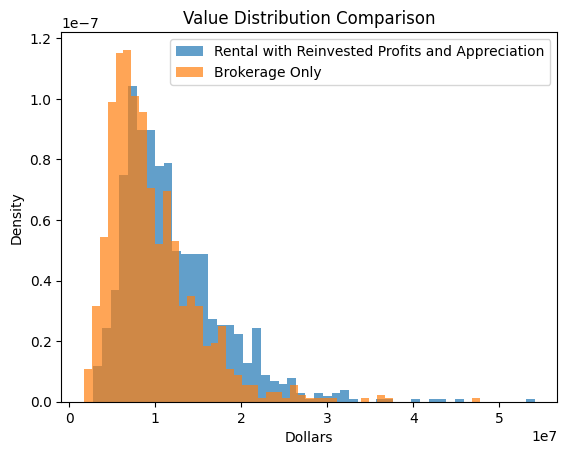

In [227]:
#Plot overlapping
plt.hist(YearlyData[:,29,3], bins=50, density = True, alpha = .7, label = 'Rental with Reinvested Profits and Appreciation')
plt.hist(YearlyData[:,29,4], bins=50, density = True, alpha = .7, label = 'Brokerage Only')
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution Comparison')
plt.legend()

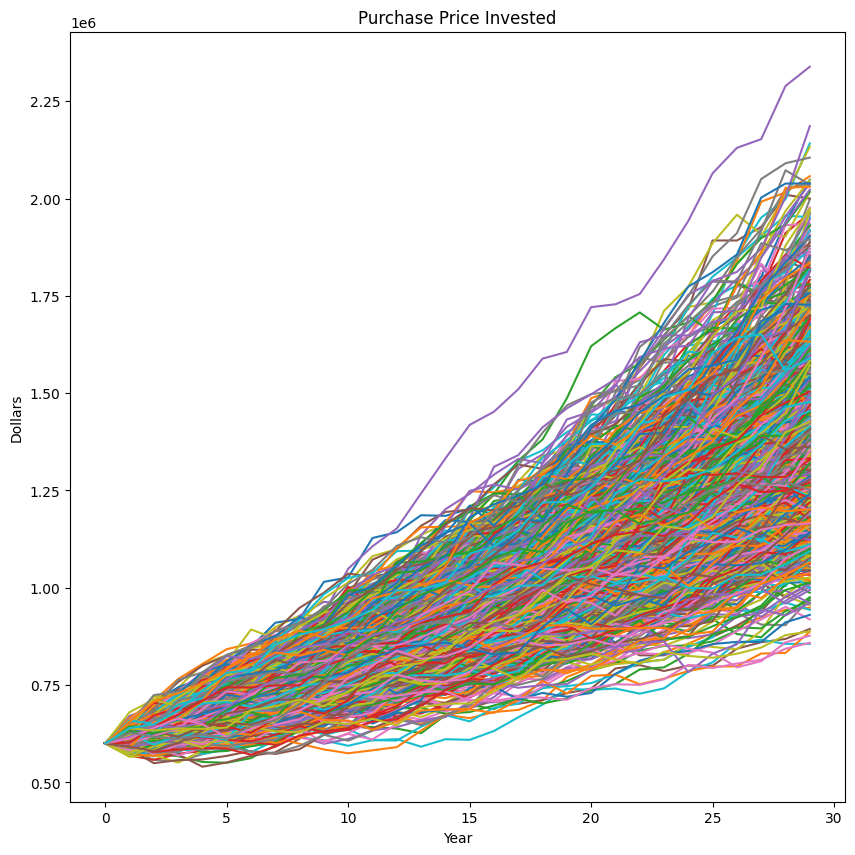

In [320]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Purchase Price Invested')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,5], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

Text(0.5, 1.0, 'Value Distribution: Rental Property Value')

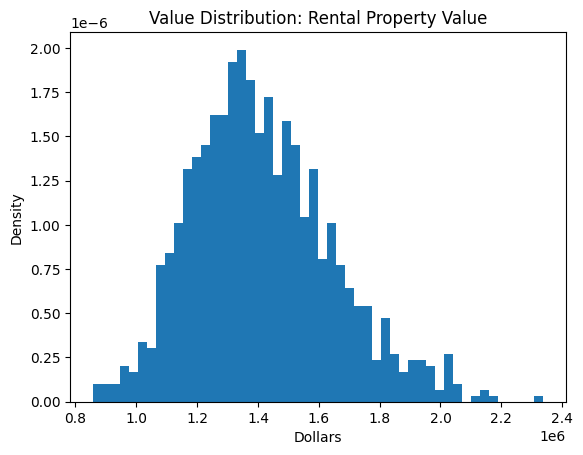

In [319]:
plt.hist(YearlyData[:,29,5], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution: Rental Property Value')


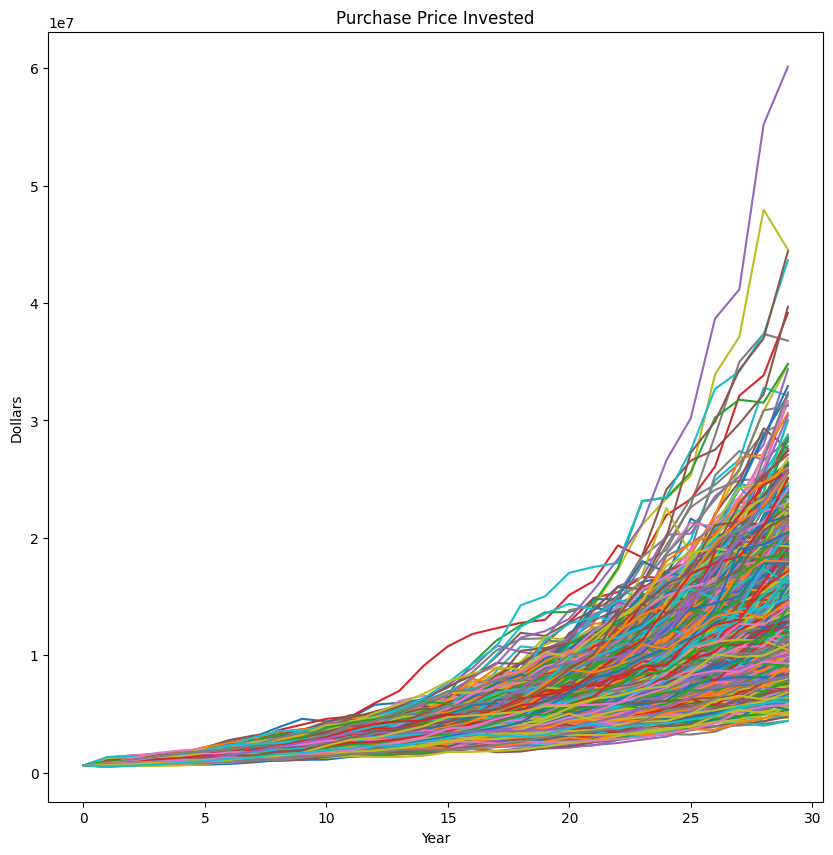

In [310]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Purchase Price Invested')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,6], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

Text(0.5, 1.0, 'Value Distribution: Rental Property Value')

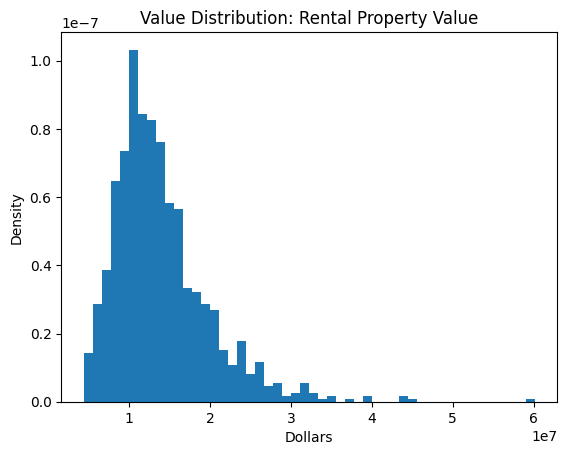

In [311]:
plt.hist(YearlyData[:,29,6], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution: Rental Property Value')


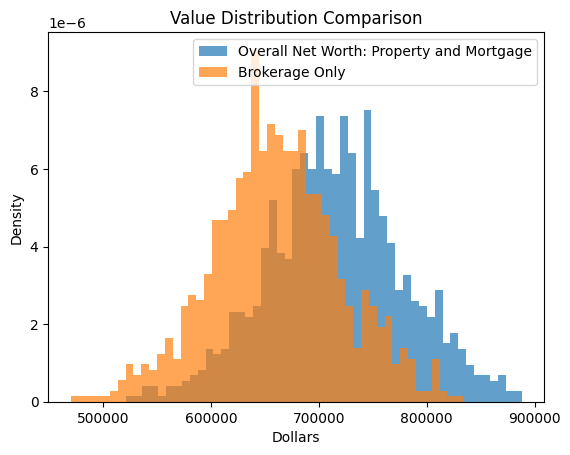

In [321]:
#Plot overlapping
plt.hist(YearlyData[:,1,6], bins=50, density = True, alpha = .7, label = 'Overall Net Worth: Property and Mortgage')
plt.hist(YearlyData[:,1,4], bins=50, density = True, alpha = .7, label = 'Brokerage Only')
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution Comparison')
plt.legend()